In [1]:
import os
import time
import copy
import h5py
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import numpy as np
import torch
import pandas as pd
import torch.nn as nn

from tqdm import trange
from torch.utils.data import TensorDataset, DataLoader
from torchsummary import summary

plt.rcParams["figure.figsize"] = (15, 15)

In [8]:

SIGNALS_NAME = [
    "AbdoBelt",
    "AirFlow",
    "PPG",
    "ThorBelt",
    "Snoring",
    "SPO2",
    "C4A1",
    "O2A1",
]

In [4]:
PATH_TO_TRAINING_DATA = "WT_train.h5"
PATH_TO_TRAINING_TARGET = "y_train_tX9Br0C.csv"

train_file = h5py.File(PATH_TO_TRAINING_DATA)
train_set = train_file['data']
masks = np.array(pd.read_csv(PATH_TO_TRAINING_TARGET))
masks = np.array(masks[:, 1:])

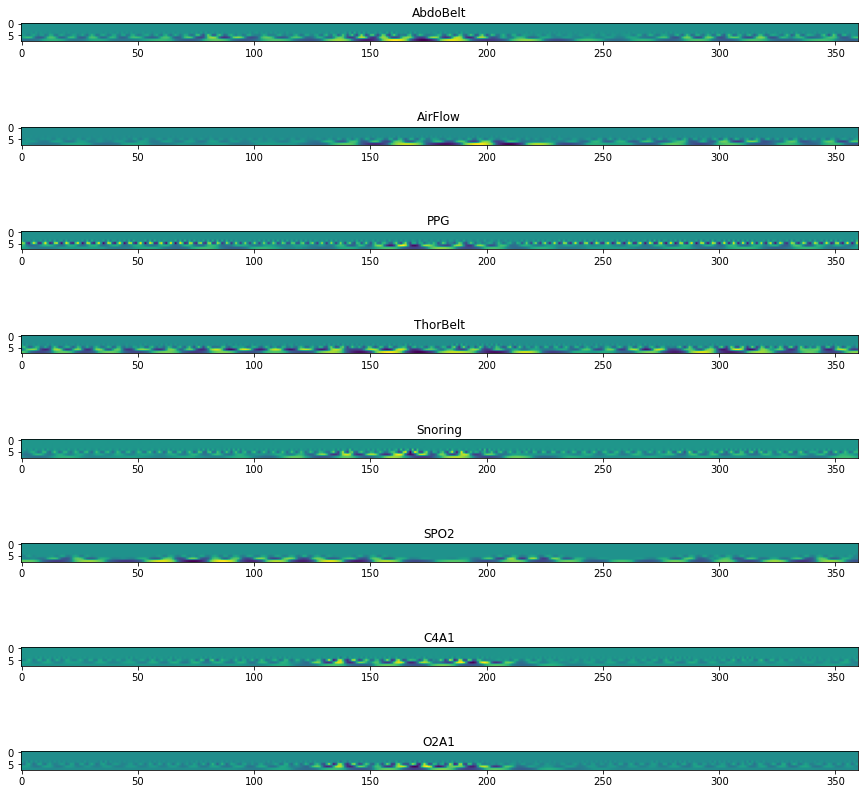

In [16]:
fig, axs = plt.subplots(len(SIGNALS_NAME))
for k,WT in enumerate(train_set[0,:]):
    axs[k].imshow(WT)
    axs[k].set_title(SIGNALS_NAME[k])

# Soft Labels

(4400, 90)


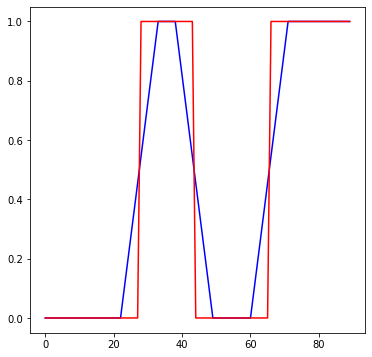

In [18]:
idx_anomaly = np.where(np.sum(masks,axis=1) > 1)[0]
soft_mask = np.zeros(masks.shape)
D = 5
N = masks.shape[1]

for k in idx_anomaly:
  target = masks[k]
  interval_target = []
  N = len(target)
  new_target = np.zeros(N)
  nb_ones = np.zeros(N)
  for i in range(N):
    x = np.zeros(N)
    x[max(0,i-D):min(N,i+D+1)] = 1
    nb_ones[i] = np.sum(x)
    new_target[i] = np.sum(target*x/nb_ones[i])
  new_target = new_target/np.max(new_target)
  soft_mask[k] = new_target

plt.figure(figsize=(6,6))
plt.plot(soft_mask[idx_anomaly[100]],color = 'blue')
plt.plot(masks[idx_anomaly[100]],color = 'red')
print(soft_mask.shape)

In [ ]:
def create_dataset(data, target):
    """Converts NumPy arrays into PyTorch datsets.
    """    
    ds = TensorDataset(
        torch.tensor(data).float(), 
        torch.tensor(target).float())
    
    return ds


def create_loader(data, bs=128, jobs=0):
    """Wraps the datasets returned by create_datasets function with data loaders."""
    dl = DataLoader(data, batch_size=bs, shuffle=True, num_workers=jobs)

    return dl

# Create dataset. Splitting into 5 for ensemble method.
# train_dataset = create_dataset(train_set, masks)
train_dataset = create_dataset(train_set, soft_mask)
splits = torch.utils.data.random_split(train_dataset, [880, 880, 880, 880, 880])

In [190]:
def C2d_layer(input, output):
    return nn.Sequential(
        nn.Conv2d(
            in_channels=input,
            out_channels=output,
            kernel_size=(1, 3),
            padding=(0, 1),
        ),
        nn.ReLU(),
    )


def block_C2d(input, output, n_layer=3):
    L = []
    L.append(C2d_layer(input, output))
    for i in range(n_layer - 1):
        L.append(C2d_layer(output, output))
    L.append(nn.MaxPool2d((1, 2)))

    return nn.Sequential(*L)


def combine_blocks(up_to=2):
    L = []
    for i in range(up_to):
        layer = block_C2d(2 ** (i + 3), 2 ** (i + 4))
        L.append(layer)

    return nn.Sequential(*L)


class WT_CNN(nn.Module):
    def __init__(self):
        super(WT_CNN, self).__init__()

        # Inputs are size 8 * N_scales (=8) * 360
        self.space_conv = nn.Conv2d(
            in_channels=8, out_channels=8, kernel_size=(1, 1)
        )

        self.time_conv = combine_blocks()

        self.classif_layer = nn.Conv2d(
            in_channels=32, out_channels=1, kernel_size=(8,1)
        )
        
        self.dp1 = nn.Dropout(p=0.2)
        self.dp2 = nn.Dropout(p=0.2)
        self.dp3 = nn.Dropout(p=0.2)

    def forward(self, x):
        """
        Apply cnn layers.
        """
        out = self.space_conv(x)
        out = self.time_conv(out)
        out = self.classif_layer(out)
        out = torch.nn.functional.sigmoid(out)
        return out


model = WT_CNN()

summary(model, (8, 8, 360))

Layer (type:depth-idx)                   Output Shape              Param #
├─Conv2d: 1-1                            [-1, 8, 8, 360]           72
├─Sequential: 1-2                        [-1, 32, 8, 90]           --
|    └─Sequential: 2-1                   [-1, 16, 8, 180]          --
|    |    └─Sequential: 3-1              [-1, 16, 8, 360]          400
|    |    └─Sequential: 3-2              [-1, 16, 8, 360]          784
|    |    └─Sequential: 3-3              [-1, 16, 8, 360]          784
|    |    └─MaxPool2d: 3-4               [-1, 16, 8, 180]          --
|    └─Sequential: 2-2                   [-1, 32, 8, 90]           --
|    |    └─Sequential: 3-5              [-1, 32, 8, 180]          1,568
|    |    └─Sequential: 3-6              [-1, 32, 8, 180]          3,104
|    |    └─Sequential: 3-7              [-1, 32, 8, 180]          3,104
|    |    └─MaxPool2d: 3-8               [-1, 32, 8, 90]           --
├─Conv2d: 1-3                            [-1, 1, 1, 90]            257
To

Layer (type:depth-idx)                   Output Shape              Param #
├─Conv2d: 1-1                            [-1, 8, 8, 360]           72
├─Sequential: 1-2                        [-1, 32, 8, 90]           --
|    └─Sequential: 2-1                   [-1, 16, 8, 180]          --
|    |    └─Sequential: 3-1              [-1, 16, 8, 360]          400
|    |    └─Sequential: 3-2              [-1, 16, 8, 360]          784
|    |    └─Sequential: 3-3              [-1, 16, 8, 360]          784
|    |    └─MaxPool2d: 3-4               [-1, 16, 8, 180]          --
|    └─Sequential: 2-2                   [-1, 32, 8, 90]           --
|    |    └─Sequential: 3-5              [-1, 32, 8, 180]          1,568
|    |    └─Sequential: 3-6              [-1, 32, 8, 180]          3,104
|    |    └─Sequential: 3-7              [-1, 32, 8, 180]          3,104
|    |    └─MaxPool2d: 3-8               [-1, 32, 8, 90]           --
├─Conv2d: 1-3                            [-1, 1, 1, 90]            257
To

In [201]:
# Cell for loss function definition
def loss_function(y_pred, y):
    """
    Calculate loss according to equations defined.
    """
    # We use binary cross entropy here
    L = nn.functional.binary_cross_entropy(y_pred, y,reduction='sum')
#     L = torch.norm(y_pred-y, 1)

    return L 

torch.Size([90])
tensor(102.2937) tensor(13.7835) tensor(9.8237)


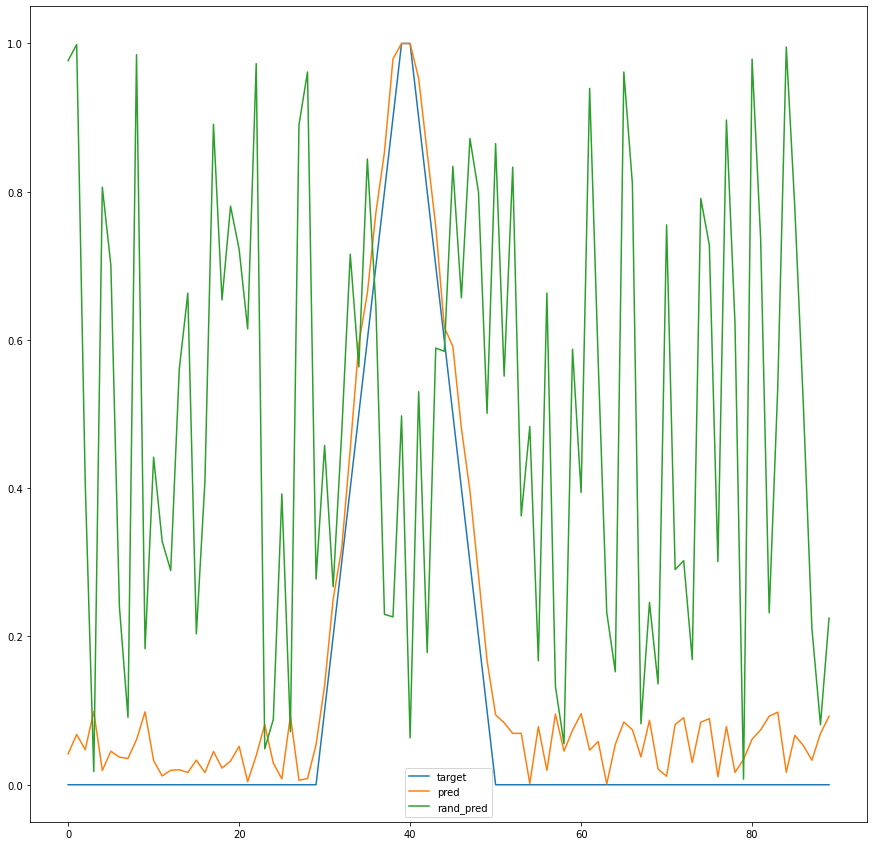

In [206]:
target = torch.Tensor(soft_mask[idx_anomaly[4]])
pred = target + 0.1*torch.rand(target.size())
pred = torch.Tensor(np.minimum(pred.numpy(),1))

plt.plot(target, label = 'target')
plt.plot(pred, label = 'pred')
plt.plot(rand_pred, label = 'rand_pred')
plt.legend()
rand_pred = torch.rand(target.size())
print(target.shape)

print(loss_function(rand_pred, target),
loss_function(pred, target),
loss_function(target, target))

In [209]:
"""
NOTE: code adapted from the following Pytorch tutorial on transfer learning.

https://pytorch.org/tutorials/beginner/finetuning_torchvision_models_tutorial.html

Training and validation exactly like starter code.
"""
def train_model(model, train_loader, val_loader, model_index):
    model_file = 'new_experiment' + '/' + model_index + '.pth'

    since = time.time()
    num_epochs = 100

    optimizer = torch.optim.Adam(params=model.parameters(), lr=0.0001)

    # Scheduler unused so far
    scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=100, gamma=0.1)

    best_acc = np.inf

    for epoch in range(num_epochs):
        epoch_acc = 0.0

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode

                for batch_idx, (data, target) in enumerate(train_loader):
                    if use_cuda:
                        data, target = data.cuda(), target.cuda()

                    optimizer.zero_grad()
                    output = model(data)
                    output = output.reshape(-1,90)
                    
                    loss = loss_function(output, target)
                    loss.backward()
                    optimizer.step()

            else:
                model.eval()   # Set model to evaluate mode

                validation_loss = 0
                correct = 0
                for data, target in val_loader:
                    if use_cuda:
                        data, target = data.cuda(), target.cuda()

                    output = model(data)
                    validation_loss += loss_function(output, target).item()

                print('Epoch {} --> validation set: total loss: {:.4f}'.format(epoch, validation_loss))
                
                epoch_acc = validation_loss

            # deep copy the model
            if phase == 'val' and epoch_acc < best_acc:
                best_acc = epoch_acc
                torch.save(model.state_dict(), model_file)
                print('--> Saved model to ' + model_file)


        scheduler.step()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))

    return model

tensor(251.9569, grad_fn=<BinaryCrossEntropyBackward>)

In [ ]:
# Create experiment folder
if not os.path.isdir('new_experiment'):
    os.makedirs('new_experiment')

batch_size = 100

use_cuda = torch.cuda.is_available()

for x in range(5):
    l = []

    for i in range(5):
        if (i == x):
            continue
        else:
            l.append(splits[i])

    models = CNN()

    if (use_cuda == True):
      models.cuda()
    
    set_to_use = torch.utils.data.ConcatDataset(l)

    train_loader = torch.utils.data.DataLoader(set_to_use, batch_size=batch_size, shuffle=True, num_workers=1)
    val_loader = torch.utils.data.DataLoader(splits[x], batch_size=batch_size, shuffle=False)    
    models = train_model(models, train_loader, val_loader, 'WT_2dcnn_{}'.format(x))

In [ ]:
# Comparison with baseline
if __name__ == '__main__':
    CSV_FILE_Y_TRUE = 'y_benchmark.csv'
    CSV_FILE_Y_PRED = 'new_experiment/results.csv'
    df_y_true = pd.read_csv(CSV_FILE_Y_TRUE, index_col=0, sep=',')
    df_y_pred = pd.read_csv(CSV_FILE_Y_PRED, index_col=0, sep=',')
    print(dreem_sleep_apnea_custom_metric(df_y_true, df_y_pred))